# **PRÀCTICA TITANIC**

Blanca Piñol Chacon 1666134

Maria Muñoz Cabestany 1668438

En aquesta practica farem servir la base de dades del titanic. L'atribut que predirem es Survived, el qual ens diu si va sobreviure o no cada passatger.

[kaggle Titanic](https://www.kaggle.com/c/titanic/data)


In [103]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
import shutil
import os

# Crear la carpeta si no existeix
os.makedirs('/root/.config/kaggle/', exist_ok=True)

# Moure kaggle.json a la carpeta corresponent
shutil.move('kaggle.json', '/root/.config/kaggle/kaggle.json')


'/root/.config/kaggle/kaggle.json'

In [107]:
#Carreguem el dataset a traves de kaggle
#primer importem la api
from kaggle.api.kaggle_api_extended import KaggleApi
import os
api = KaggleApi()
api.authenticate()

In [109]:
from zipfile import ZipFile
dataset_name= 'titanic'

if not os.path.isdir('data'):
  os.mkdir('data')

file_names = ['gender_submission.csv', 'test.csv', 'train.csv']

api.competition_download_files(dataset_name,path = 'data')
zf = ZipFile(f'data/{dataset_name}.zip')
zf.extractall(f'data/{dataset_name}')
zf.close()

for file_name in file_names:
    api.competition_download_file(dataset_name, file_name, path='data')

gender_submission = pd.read_csv(f'data/{dataset_name}/gender_submission.csv')
test = pd.read_csv(f'data/{dataset_name}/test.csv')
df = pd.read_csv(f'data/{dataset_name}/train.csv')

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


### EDA (exploratory data analysis)

L'objectiu d'aquest treball és predir la supervivència dels passatgers del Titanic utilitzant tècniques d'aprenentatge automàtic. Tanmateix, abans de començar amb les prediccions, és important tenir una bona comprensió de la base de dades amb la qual estem treballant. Per això, primer farem un anàlisi de les dades del naufragi del Titanic mitjançant una exploració de les dades (EDA). Això ens permetrà tenir una visió clara de com són les dades i ens ajudarà a identificar possibles problemes que podrien afectar els resultats del model.

Principalment, hem examinat la tipologia i el tamany de les dades, valorat les correlacions entre les variables i fet un primer anàlisi de la variable objectiu Survived.

In [110]:
# Mirem els atributs
print(df.keys())

#Mirem el tipus d'atributs
print(df.dtypes)

#Mirem el tamany
print(df.size)

#Mirem descripcio general
df.describe()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
10692


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [111]:
numeric_features = df.select_dtypes(np.number).keys()
print(numeric_features)
non_numeric = [k for k in df.keys() if k not in numeric_features]
print(non_numeric)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Podem veure que a la base de dades hi ha 12 atributs, dels quals 5 són categòrics i 7 numérics.

In [112]:
unique_values = df['Survived'].unique()
print(unique_values)

[0 1]


Survived és una variable binària que ens indica si una persona ha sobreviscut(1) o ha mort(0) al naufragi del Titanic. El nostre objectiu és predir amb la resta de variables de la base de dades si Survived serà 0 o 1.

Mirem la distribució de cada variable del conjunt de dades:

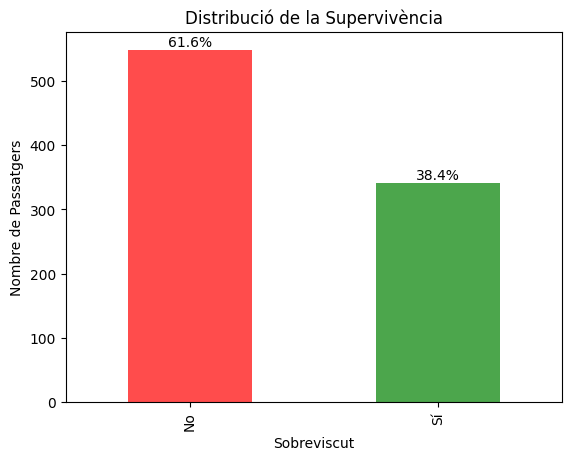

In [113]:
survived_counts = df['Survived'].value_counts()
survived_percentatges = survived_counts / survived_counts.sum() * 100

ax = survived_counts.plot(kind='bar', color=['red', 'green'], alpha=0.7)

plt.title('Distribució de la Supervivència')
plt.xlabel('Sobreviscut')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.ylabel('Nombre de Passatgers')

for i, count in enumerate(survived_counts):
    percentage = survived_percentatges[i]
    ax.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()


Podem veure com més de la meitat de les persones (un 61,6%) no van sobreviure al naufragi del Titanic. Aquest desequilibri en les etiquetes indica que les dades estan desbalancejades, fet que pot influir en els resultats dels models de classificació, ja que hi ha una major representació de persones que no van sobreviure.

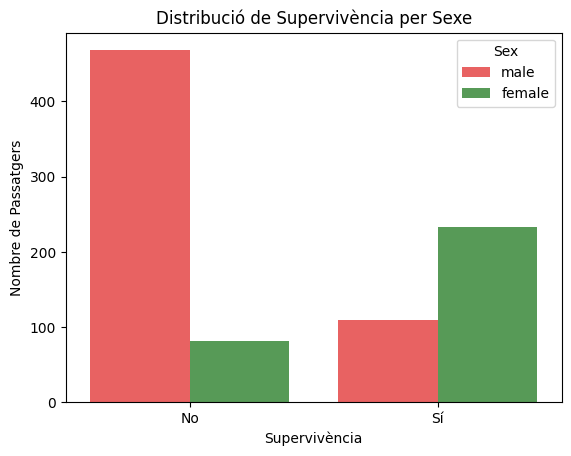

In [114]:
sns.countplot(data=df, x='Survived', hue='Sex', palette=['red', 'green'], alpha=0.7)
plt.title('Distribució de Supervivència per Sexe')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

Observem que la proporció de dones que van sobreviure és molt major que la d'homes. Segurament aquest fet es degui a que les dones i els nens van tenir prioritat a l'hora d'abandonar el vaixell.

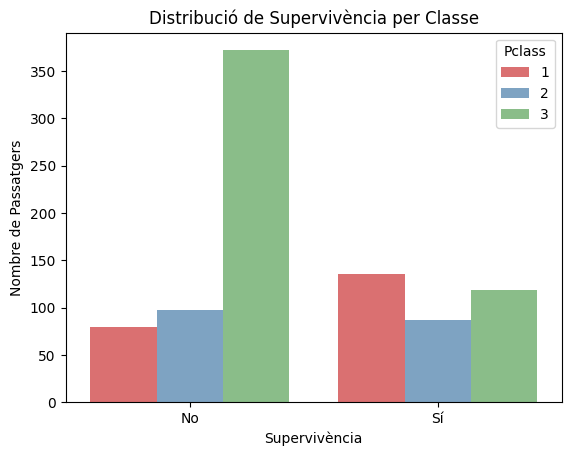

In [115]:
sns.countplot(data=df, x='Survived', hue='Pclass', palette='Set1', alpha=0.7)
plt.title('Distribució de Supervivència per Classe')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

Com podiem imaginar, el gràfic ens mostra que les persones que no es van poder salvar eren, en gran majoria, persones que viatjaven en tercera classe. És a dir, persones amb menys recursos. En canvi, els passatgers que viatjaven en primera classe són els que més van sobreviure.

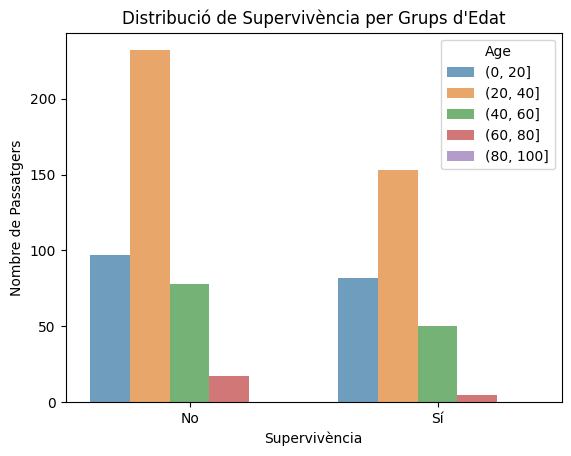

In [116]:
age_bins = pd.cut(df['Age'], bins=[0,20,40,60,80,100])
sns.countplot(data=df, x='Survived', hue=age_bins, alpha=0.7)
plt.title('Distribució de Supervivència per Grups d\'Edat')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

Al Titanic, el grup d'edat més abundant era el d'entre 20 i 40 anys, en el qual hi va haver més morts que supervivents.
Pel que fa al grup de passatgers menors de 20 anys, és el que mostra una distribució més equilibrada entre morts i supervivents, això es deu a que els nens i joves tenien prioritat a l'hora d'abandonar el vaixell. Tot i així, la seva fragilitat i menor resistència física podien afectar les seves possibilitats de sobreviure.

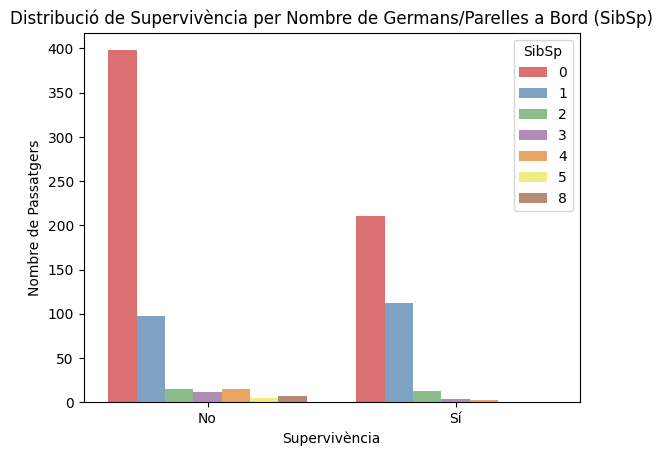

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(data=df, x='Survived', hue='SibSp', palette='Set1', alpha=0.7)

plt.title('Distribució de Supervivència per Nombre de Germans/Parelles a Bord (SibSp)')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])

plt.show()


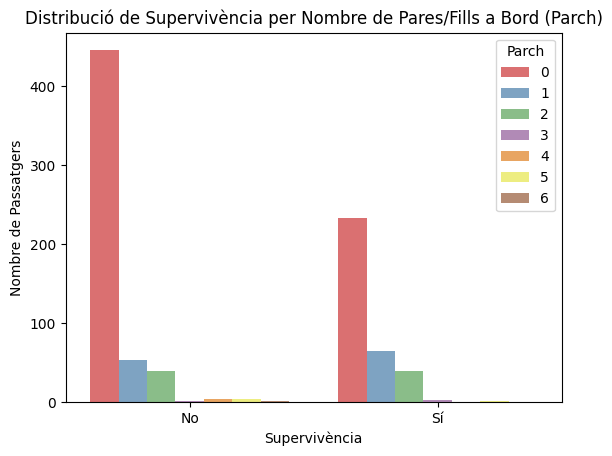

In [121]:
sns.countplot(data=df, x='Survived', hue='Parch', palette='Set1', alpha=0.7)
plt.title('Distribució de Supervivència per Nombre de Pares/Fills a Bord (Parch)')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

En tots dos casos, els passatgers que viatjaven sols (tant sense germans/parelles com sense pares/fills) o amb molts acompanyants tenien menys probabilitats de sobreviure. En canvi, aquells que viatjaven amb un o dos acompanyants semblen haver tingut més possibilitats de salvar-se. Això podria deures a diversos factors, com ara una millor coordinació per accedir als bots salvavides o menys dificultats per moures dins del vaixell durant l'evacuació. Els passatgers amb moltes persones a càrrec potser van trobar-se amb més dificultats logístiques per salvar-se tots junts, fet que podria explicar les taxes més baixes de supervivència en aquests casos.

Tot i així, pel que fa al conjunt de dades que analitzem, en els gràfic del SibSp i del parch no acabem de veure una corrrelació clara.

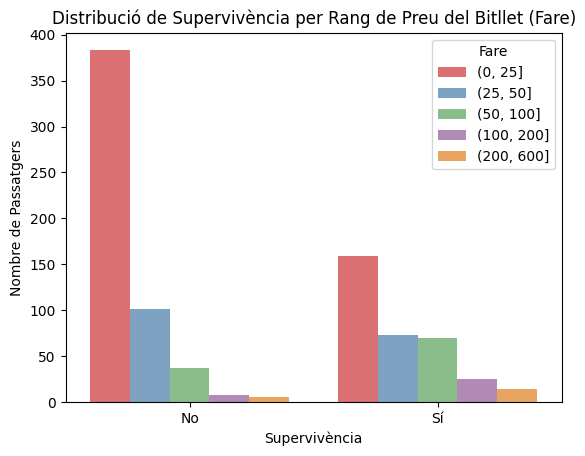

In [122]:
fare_bins = pd.cut(df['Fare'], bins=[0, 25, 50, 100, 200, 600])
sns.countplot(data=df, x='Survived', hue=fare_bins, palette='Set1', alpha=0.7)
plt.title('Distribució de Supervivència per Rang de Preu del Bitllet (Fare)')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

Podem dir que hi havia una major quantitat de passatgers de classe baixa al vaixell que no pas de classe alta, probablement perquè les condicions que prometien els bitllets més barats requerien menys espai i menys luxes que no pas els més cars i, per tant, n'hi havia més de disponibles.

Com ja haviem vist, els passatgers de classe baixa van sobreviure en mernor proporció al naufragi. Això es podria ser perquè aquests passatgers estaven allotjats a les cobertes més baixes del vaixell, fet que dificultava l'accés ràpid als bots salvavides i augmentava les dificultats per evacuar durant l'emergència.

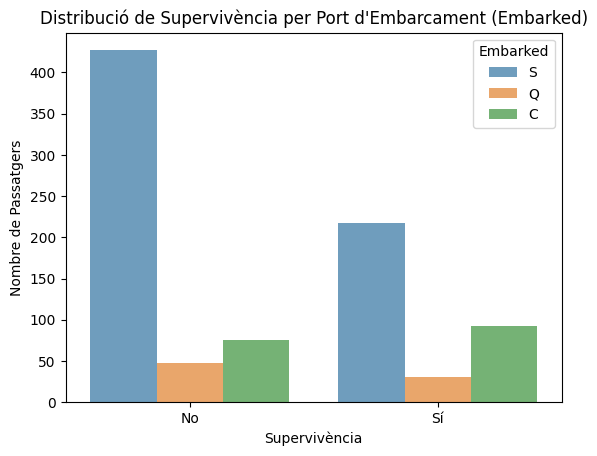

In [123]:
sns.countplot(data=df, x='Survived', hue='Embarked', alpha=0.7)
plt.title('Distribució de Supervivència per Port d\'Embarcament (Embarked)')
plt.xlabel('Supervivència')
plt.ylabel('Nombre de Passatgers')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.show()

Entre el total de passatgers, aquells que van embarcar a Southampton van morir a causa del naufragi en una proporció major. Si més no, segueix havent-hi una quantitat considerable de supervivents que van embarcar en aquest mateix port. Per comprendre millor aquesta relació, caldria analitzar la connexió entre la tarifa del bitllet i les probabilitats de supervivència, ja que el preu podria reflectir la classe en què viatjaven i, per tant, l'accés als recursos de rescat.

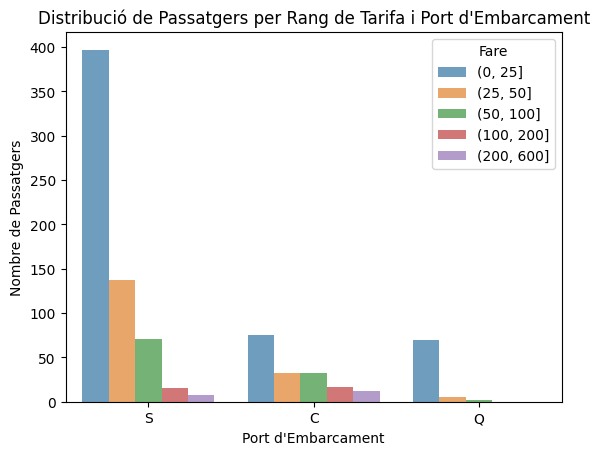

In [124]:
sns.countplot(data=df, x='Embarked', hue=fare_bins, alpha=0.7)
plt.title('Distribució de Passatgers per Rang de Tarifa i Port d\'Embarcament')
plt.xlabel('Port d\'Embarcament')
plt.ylabel('Nombre de Passatgers')
plt.show()

Aquest anàlisi mostra que Southampton va ser el port d'embarcament principal per als passatgers del Titanic, en gran part perquè els bitllets adquirits en aquest port eren els més econòmics. Això va fer que la majoria de viatgers que van embarcar a Southampton fossin de classe baixa.

Per finalitzar l'exploració de dades del nostre Dataset i per tal d'identificar quant poden influir o com d'associades poden estar les diferents variables amb la probabilitat de supervivència dels passatgers, hem volgut analitzar les correlacions de les variables numériques.

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


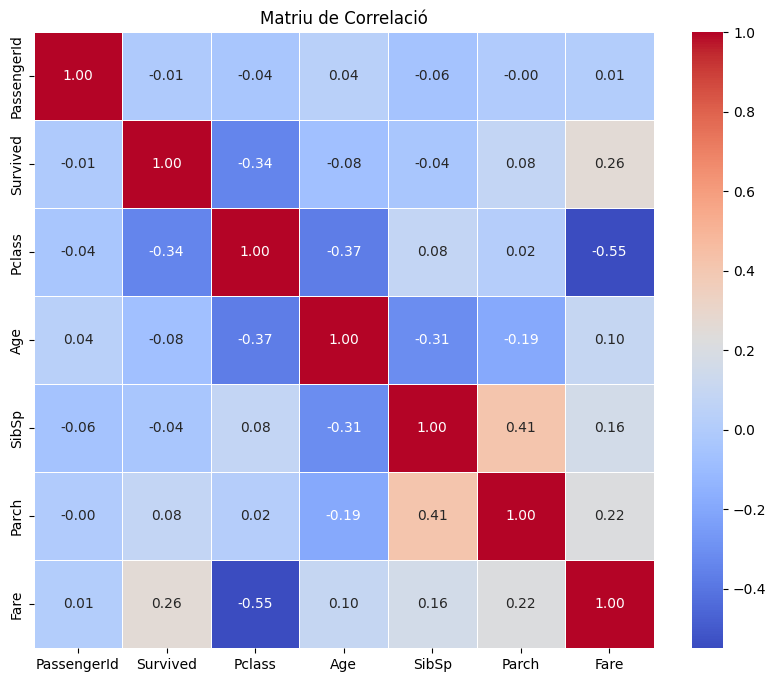

In [126]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriu de correlació només de les variables numèriques
correlation_matrix = numeric_features.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriu de Correlació')
plt.show()

Ens fixem en la correlació de la variable "Survived" amb les altres variables independents del conjunt de dades. Veiem que les variables amb una relació més forta amb la supervivència són el cost del bitllet, l'edat i la classe social. Entre la resta de dades, com podiem esperar, les que presenten una correlació major són la classe en la que es viatjava i el preu del billet.
Tot i així, cal tenir en compte que aquesta taula de correlacions no inclou variables com el sexe o el lloc d'embarcament, que també podrien tenir un impacte significatiu en les probabilitats de supervivència.

---
###PREPROCESSING


Després de veure les dades de les que disposem, cal preparar-les per als nostres algoritmes. En aquest cas, decidirem que fem amb els nans que apareixen, codificarem valeriables categóriques en valors numèrics, normalitzarem les dades i veurem si ens cal alguna altra tècnica per tal de deixar el conjunt de dades adequat segons les nostres necessitats.

El primer pas és verificar la presència de nans en el conjunt de dades i determinar la seva proporció.

In [127]:
#Mirem les columnes amb nans del train
nan_columns = df.columns[df.isna().sum()>0].tolist()
nan_counts = df[nan_columns].isna().sum()
nan_percentatges = (nan_counts / len(df)) * 100
missing_data = pd.concat([nan_counts, nan_percentatges], axis=1, keys=['Total', '%'])

print(missing_data)

          Total          %
Age         177  19.865320
Cabin       687  77.104377
Embarked      2   0.224467


A la columna Cabin, hi ha 687 valors nuls, que representen aproximadament un 77% del total de les dades. La columna Age presenta un 20% de valors nuls, mentre que Embarked té només un 0,2%.

Observem que la columna 'Cabin' conté una quantitat molt elevada de valors nuls, la qual cosa indica que no aporta informació rellevant per a l'anàlisi de dades. Per tant, decidim eliminar aquesta columna.

In [128]:
df.drop(['Cabin'], axis=1, inplace=True)

També hem decidit eliminar les variables Name, Ticket i PassengerID, ja que considerem que no aporten informació significativa per a l'anàlisi

In [129]:
df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

La variable 'Sex', que pot ser 'male' o 'female', la transformem en 0 o 1.

In [130]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

Només ens queda tractar els valors nuls de les columnes Embarked i Age.

Primer, realitzarem One-Hot Encoding sobre Embarked, per seguidament eliminar aquesta mateixa.

El One-Hot Encoding és una tècnica que converteix variables categòriques en columnes binàries, assignant un 1 a la categoria present i un 0 a les altres

In [131]:
!pip install category_encoders
import category_encoders as ce
from category_encoders.binary import BinaryEncoder

oe = BinaryEncoder()
df_embarked = oe.fit_transform(df['Embarked'])

print("Columnas generadas:", df_embarked.columns)

if 'Embarked_0' in df_embarked.columns:
    df['Embarked_Q'] = df_embarked['Embarked_0']
if 'Embarked_1' in df_embarked.columns:
    df['Embarked_C'] = df_embarked['Embarked_1']
if 'Embarked_2' in df_embarked.columns:
    df['Embarked_S'] = df_embarked['Embarked_2']

df.drop(['Embarked'], axis=1, inplace=True)
print("Columnas del DataFrame final:", df.columns)
df.head(62)


Columnas generadas: Index(['Embarked_0', 'Embarked_1', 'Embarked_2'], dtype='object')
Columnas del DataFrame final: Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Q', 'Embarked_C', 'Embarked_S'],
      dtype='object')


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_C,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
57,0,3,0,28.5,0,0,7.2292,0,1,0
58,1,2,1,5.0,1,2,27.7500,0,0,1
59,0,3,0,11.0,5,2,46.9000,0,0,1
60,0,3,0,22.0,0,0,7.2292,0,1,0


Un cop fet l'Encoding i abans de tractar els nans, normailitzem les dades:

In [132]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

llista=['Pclass','Age','SibSp','Parch','Fare']
df.loc[:,llista] = sc.fit_transform(df.loc[:,llista])

<ipython-input-132-edd4fb8433f1>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.82737724 -1.56610693  0.82737724 -1.56610693  0.82737724  0.82737724
 -1.56610693  0.82737724  0.82737724 -0.36936484  0.82737724 -1.56610693
  0.82737724  0.82737724  0.82737724 -0.36936484  0.82737724 -0.36936484
  0.82737724  0.82737724 -0.36936484 -0.36936484  0.82737724 -1.56610693
  0.82737724  0.82737724  0.82737724 -1.56610693  0.82737724  0.82737724
 -1.56610693 -1.56610693  0.82737724 -0.36936484 -1.56610693 -1.56610693
  0.82737724  0.82737724  0.82737724  0.82737724  0.82737724 -0.36936484
  0.82737724 -0.36936484  0.82737724  0.82737724  0.82737724  0.82737724
  0.82737724  0.82737724  0.82737724  0.82737724 -1.56610693 -0.36936484
 -1.56610693 -1.56610693 -0.36936484  0.82737724 -0.36936484  0.82737724
  0.82737724 -1.56610693 -1.56610693  0.82737724 -1.56610693  0.82737724
 -0.36936484  0.82737724  0.82737724  0.827

Per gestionar els valors nuls a la columna Age, hem substituït els valors nuls per la mitjana d'edat dels passatgers que viatjaven en la mateixa classe (Pclass) i tenien el mateix sexe (Sex). Aquesta estratègia és més precisa, ja que tant la classe com el sexe estan altament correlacionats amb la supervivència i fer la mitjana general de les edats sense tenir en compte aquestes variables ens donava una menor precissió en el model.

 Després, s'utilitza l'imputer KNN per omplir els valors nuls a les columnes Embarked_Q, Embarked_C i Embarked_S, buscant els veïns més propers per fer-ho.

In [133]:
from sklearn.impute import KNNImputer

#mitjana per grup de classe i sexe
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))

#veïns més propers
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df[['Embarked_Q', 'Embarked_C', 'Embarked_S']] = imputer.fit_transform(df[['Embarked_Q', 'Embarked_C', 'Embarked_S']])

In [134]:
df.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_C,Embarked_S
0,0,0.827377,0,-0.530377,0.432793,-0.473674,-0.502445,0.0,0.0,1.0
1,1,-1.566107,1,0.571831,0.432793,-0.473674,0.786845,0.0,1.0,0.0
2,1,0.827377,1,-0.254825,-0.474545,-0.473674,-0.488854,0.0,0.0,1.0
3,1,-1.566107,1,0.365167,0.432793,-0.473674,0.420730,0.0,0.0,1.0
4,0,0.827377,0,0.365167,-0.474545,-0.473674,-0.486337,0.0,0.0,1.0
5,0,0.827377,0,-0.219858,-0.474545,-0.473674,-0.478116,0.0,1.0,1.0
6,0,-1.566107,0,1.674039,-0.474545,-0.473674,0.395814,0.0,0.0,1.0
7,0,0.827377,0,-1.908136,2.247470,0.767630,-0.224083,0.0,0.0,1.0
8,1,0.827377,1,-0.185937,-0.474545,2.008933,-0.424256,0.0,0.0,1.0
9,1,-0.369365,1,-1.081480,0.432793,-0.473674,-0.042956,0.0,1.0,0.0


Ara que hem tractat les dades, revisem novament les correlacions entre les variables

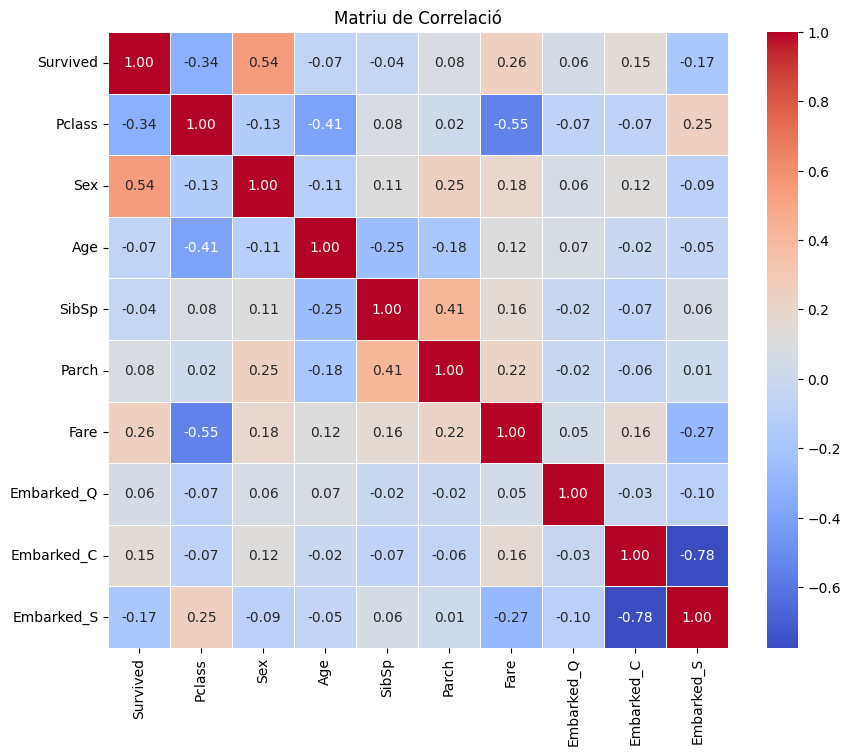

In [135]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriu de Correlació')
plt.show()

Fixant-nos en aquesta nova matriu de correlacions, que ara sí que inclou variables com el sexe (Sex) i el lloc d'embarcament (Embarked), veiem que la correlació positiva més forta es dona amb el sexe (Sex, 0.54), indicant que ser dona augmentava molt considerablement les probabilitats de sobreviure. Això reflecteix la norma seguida durant el rescat, on les dones tenien prioritat.

Pel que fa al lloc d'embarcament, Embarked_C (Cherbourg) té una correlació positiva moderada (0.15) amb la supervivència, mentre que Embarked_S (Southampton) presenta una correlació negativa (-0.17), la qual cosa confirma el que haviem vist amb els grafics.

Les variables Sex, Pclass i Fare són les que presenten les correlacions més fortes amb la supervivència.



Provem si funciona l'Anàlisi de Components Principals (PCA). Aquesta tècnica ens permet reduir la dimensionalitat del conjunt de dades, mantenint alhora la màxima variància possible.

Variança explicada per cada component: [0.24259638 0.19583206 0.16156131]
Variança total explicada: 0.5999897600262419


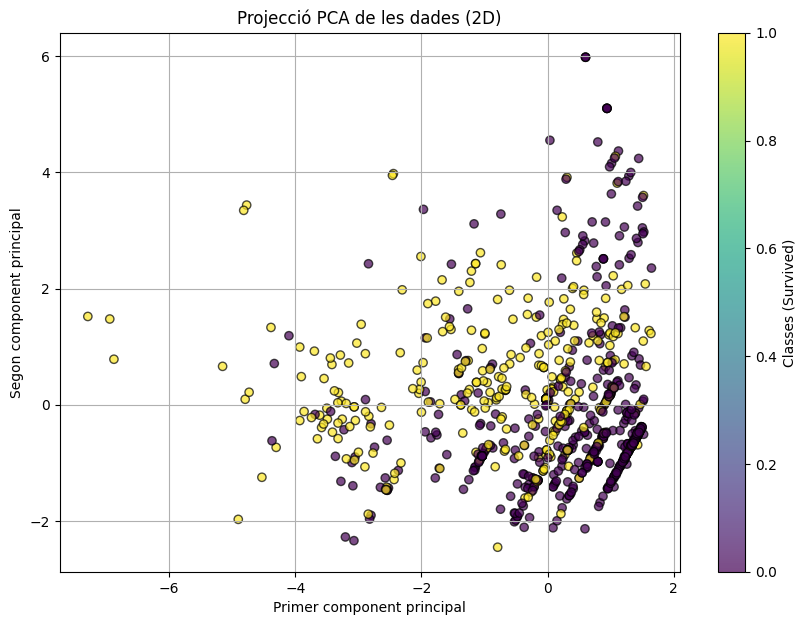

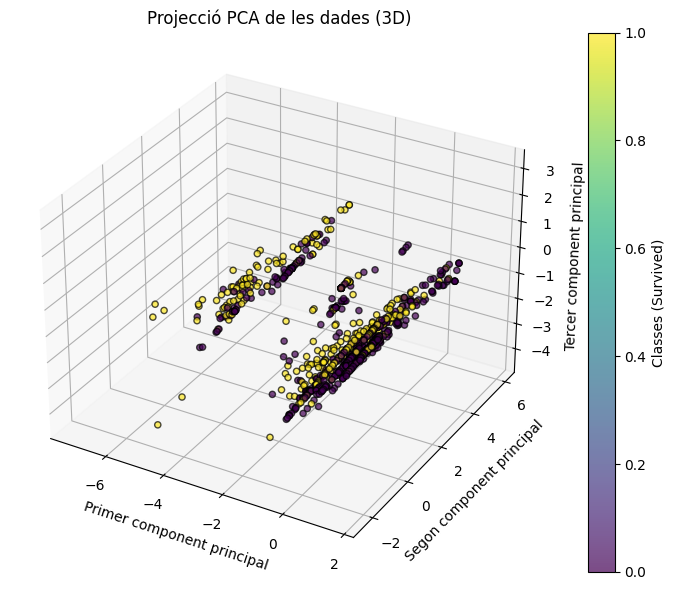

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_train = df.drop('Survived', axis=1)
y_train = df['Survived']

sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train)

n_components = 3
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(X_train_normalized)

print(f'Variança explicada per cada component: {pca.explained_variance_ratio_}')
print(f'Variança total explicada: {sum(pca.explained_variance_ratio_)}')

plt.figure(figsize=(10, 7))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Primer component principal')
plt.ylabel('Segon component principal')
plt.title('Projecció PCA de les dades (2D)')

plt.colorbar(label='Classes (Survived)')
plt.grid()
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_pca[:, 0], train_pca[:, 1], train_pca[:, 2], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7)

ax.set_xlabel('Primer component principal')
ax.set_ylabel('Segon component principal')
ax.set_zlabel('Tercer component principal')
plt.title('Projecció PCA de les dades (3D)')
plt.colorbar(scatter, label='Classes (Survived)')
plt.show()

En aquest cas, veiem que el PCA no és adequat. Això es deu a que les característiques rellevants per a la supervivència no són lineals i el PCA no pot capturar aquestes relacions complexes. A més, el dataset té una clara separació categòrica (supervivents vs. no supervivents), i el PCA no se centra a separar bé aquestes classes.




Hem decidit no aplicar PolynomialFeatures, que és una tècnica que permet modelar relacions no lineals entre les variables, ja que estem treballant amb una variable binària (0 o 1) que indica si una persona ha sobreviscut o no.

---
###METRIC SELECTION

En aquesta part, ens centrem en les mètriques de classificació. Separem la X i la y i entrenem en regressió logística per tal de trobar la millor mètrica.

In [137]:
X = df.drop('Survived', axis=1)  # Característiques
y = df['Survived']                # Variable objectiu

In [138]:
print(df.keys())

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Q', 'Embarked_C', 'Embarked_S'],
      dtype='object')


In [139]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X, y)
y_pred = lr.predict(X)


Per desenvolupar un bon model, hem triat les mètriques més adequades per predir la variable binària 'Survived'.

Les mètriques que considerem són:

* Accuracy: Mesura la proporció d'exemples classificats correctament (tant
positius com negatius) en relació amb el total d'exemples. Es calcula com (TP + TN) / Total. L'accuracy és útil en conjunts de dades equilibrats, però pot ser enganyosa en conjunts no equilibrats.

* Precision: Representa la proporció d'instàncies classificades com a positives que són realment positives. Es calcula com: Precision = TP / (TP + FP) (on TP són els veritables positius i FP els falsos positius). Aquesta mètrica indica la capacitat del model per evitar falsos positius.

* Recall: Indica la proporció d'exemples positius que el model classifica correctament com a positius. Es calcula com: Recall = TP / (TP + FN) (on FN són els falsos negatius). El recall mesura la capacitat del model per identificar tots els exemples positius reals.

* F1 Score: És la mitjana harmònica de la precisió i el recall, proporcionant un equilibri entre aquestes dues mètriques. Es calcula com: F1-Score = 2 * (Precision * Recall) / (Precision + Recall). El F1-Score és útil quan volem considerar tant els falsos positius com els falsos negatius i buscar un equilibri entre ells.

Calculem aquestes mètriques i la seva corresponent matriu de confusió

In [140]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

conf = confusion_matrix(y,y_pred)
prec,rec,f1, sup = precision_recall_fscore_support(y,y_pred)

In [141]:
print (conf)
print ()
print (prec,rec,f1, sup)

[[480  69]
 [101 241]]

[0.82616179 0.77741935] [0.87431694 0.70467836] [0.84955752 0.7392638 ] [549 342]


Generem un gràfic de la matriu de confusió en percentatges per facilitar-ne la interpretació.

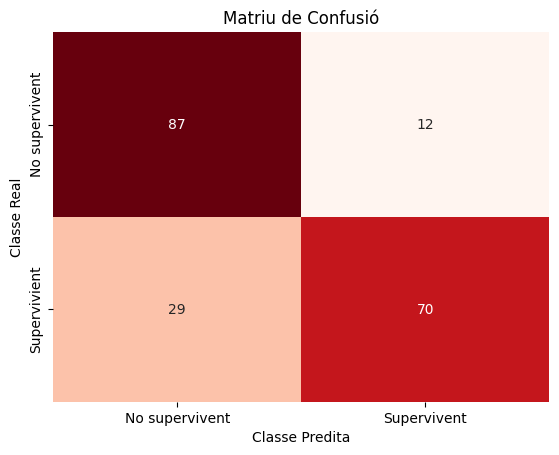

In [142]:
conf_perc=np.array(100*conf.T/conf.sum(axis = 1),dtype = int).T
sns.heatmap(conf_perc, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=['No supervivent', 'Supervivent'], yticklabels=['No supervivent', 'Supervivient'])

plt.title('Matriu de Confusió')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')

plt.show()

Com que volem gestionar els falsos negatius i els falsos positius de manera equitativa, hem decidit utilitzar el F1-score com a mètrica principal. Aquesta mètrica és especialment útil en situacions en què és important no només identificar els casos positius correctament (recall), sinó també minimitzar el nombre de casos classificats incorrectament com a positius (precisió).

Un cop hem escollit el F1-score com a mètrica per avaluar el rendiment del model, explorarem si ajustar el llindar (threshold) de classificació pot proporcionar-nos millors resultats.

In [143]:
probs = lr.predict_proba(X)  # Probabilitats per a totes les classes
print(probs)

[[0.91003542 0.08996458]
 [0.08225985 0.91774015]
 [0.3919328  0.6080672 ]
 ...
 [0.46065808 0.53934192]
 [0.35505279 0.64494721]
 [0.89728537 0.10271463]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.0
Precisió: [0.         0.38383838]
Record: [0. 1.]
Puntuació F1: [0.         0.55474453]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[  0 100]
 [  0 100]]
------------------------------


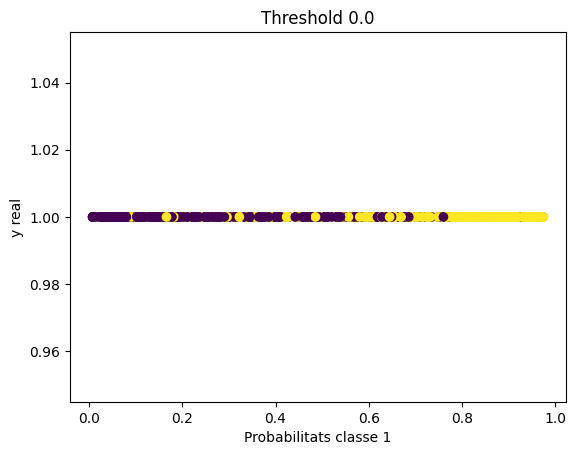

Threshold: 0.1
Precisió: [0.89261745 0.4393531 ]
Record: [0.24225865 0.95321637]
Puntuació F1: [0.38108883 0.60147601]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[24 75]
 [ 4 95]]
------------------------------


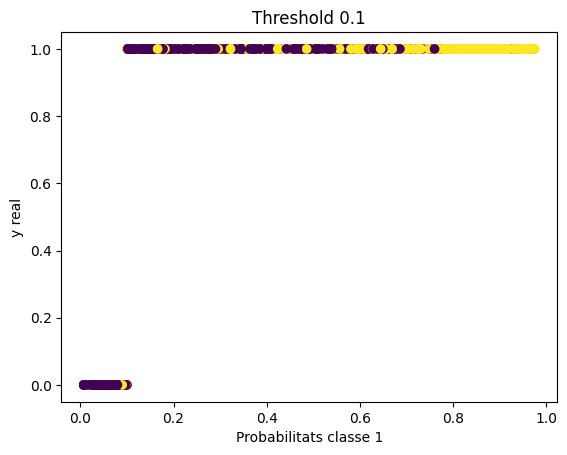

Threshold: 0.2
Precisió: [0.87435897 0.58483034]
Record: [0.62112933 0.85672515]
Puntuació F1: [0.72630458 0.69513642]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[62 37]
 [14 85]]
------------------------------


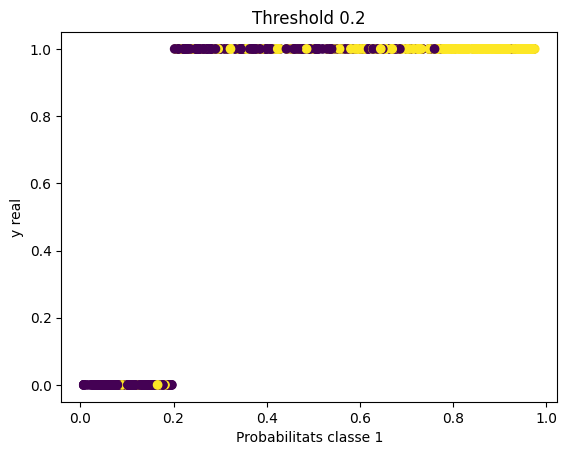

Threshold: 0.3
Precisió: [0.87152034 0.66509434]
Record: [0.74134791 0.8245614 ]
Puntuació F1: [0.8011811  0.73629243]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[74 25]
 [17 82]]
------------------------------


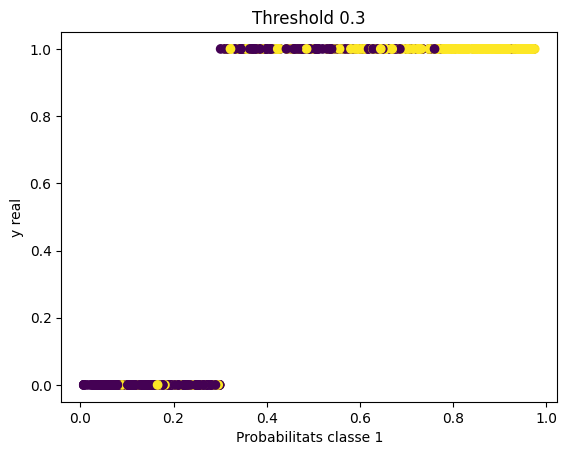

Threshold: 0.4
Precisió: [0.84644195 0.72829132]
Record: [0.82331512 0.76023392]
Puntuació F1: [0.83471837 0.74391989]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[82 17]
 [23 76]]
------------------------------


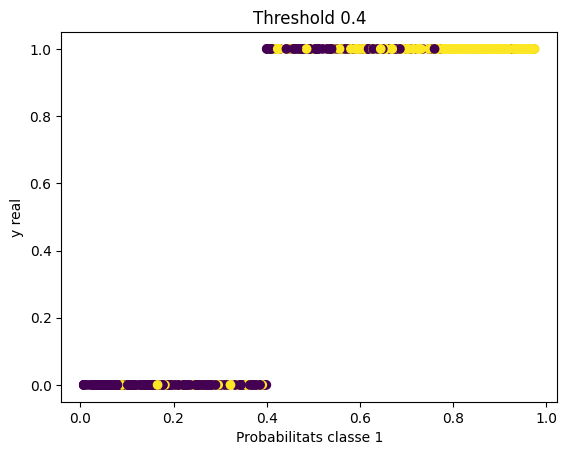

Threshold: 0.5
Precisió: [0.82616179 0.77741935]
Record: [0.87431694 0.70467836]
Puntuació F1: [0.84955752 0.7392638 ]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[87 12]
 [29 70]]
------------------------------


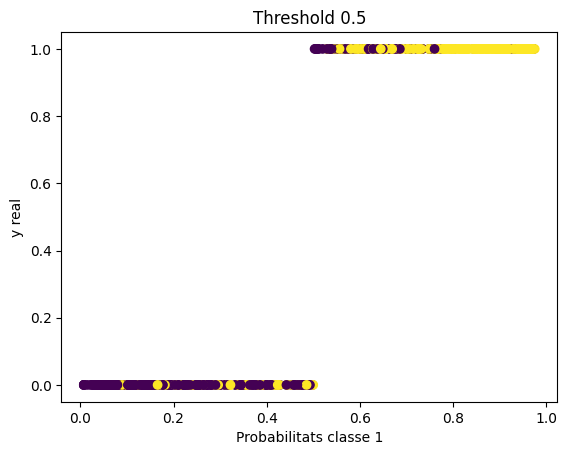

Threshold: 0.6
Precisió: [0.80573248 0.8365019 ]
Record: [0.92167577 0.64327485]
Puntuació F1: [0.85981308 0.72727273]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[92  7]
 [35 64]]
------------------------------


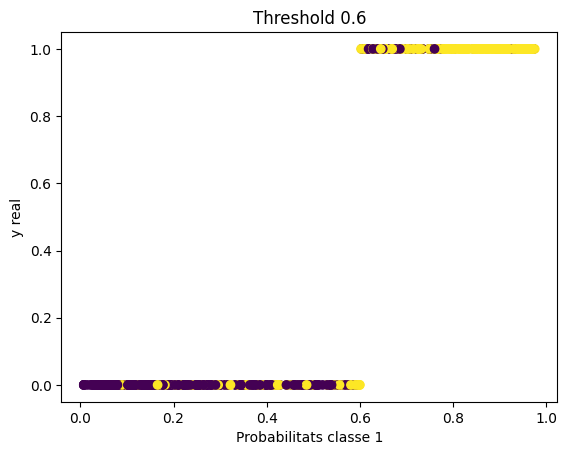

Threshold: 0.7
Precisió: [0.775     0.8957346]
Record: [0.95992714 0.55263158]
Puntuació F1: [0.85760781 0.6835443 ]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[95  4]
 [44 55]]
------------------------------


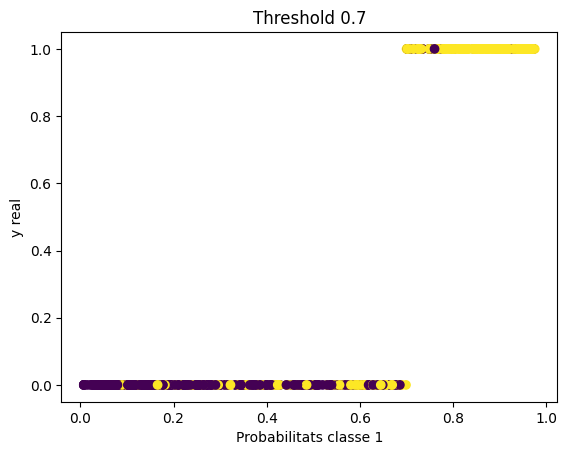

Threshold: 0.8
Precisió: [0.71578947 0.96183206]
Record: [0.99089253 0.36842105]
Puntuació F1: [0.83116883 0.53276956]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[99  0]
 [63 36]]
------------------------------


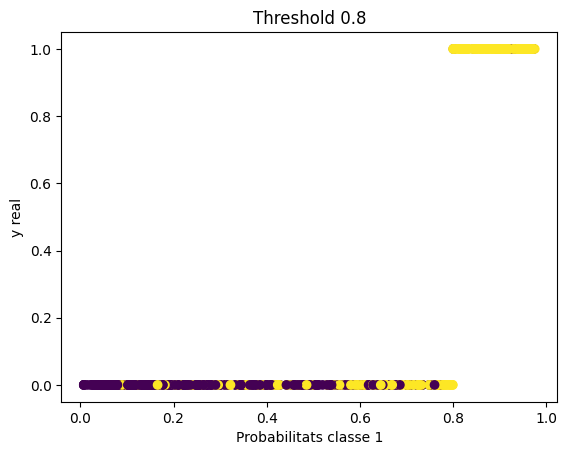

Threshold: 0.9
Precisió: [0.66626066 0.97142857]
Record: [0.99635701 0.19883041]
Puntuació F1: [0.79854015 0.33009709]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[99  0]
 [80 19]]
------------------------------


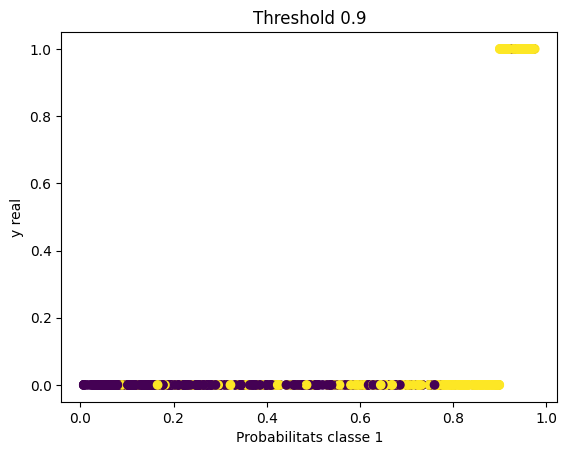

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 1.0
Precisió: [0.61616162 0.        ]
Record: [1. 0.]
Puntuació F1: [0.7625 0.    ]
Suport: [549 342]
Matriu de Confusió (Percentatge):
[[100   0]
 [100   0]]
------------------------------


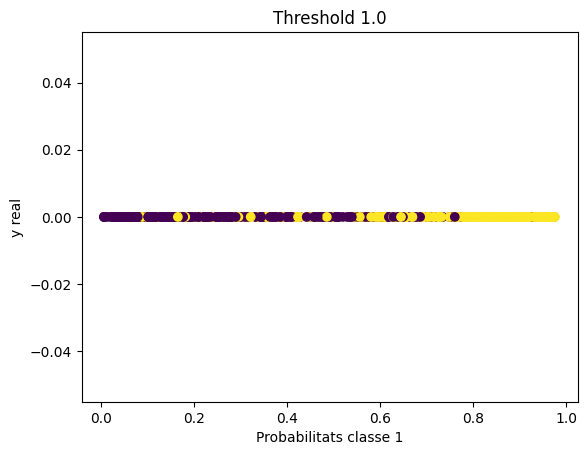

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

y_pred_prob = probs[:, 1]  # Probabilitats per a la classe 1
llindars = np.arange(0.0, 1.1, 0.1)
confusion_matrices = []

for llindar in llindars:
    y_pred1 = (y_pred_prob >= llindar).astype(int)
    prec, rec, f1, sup = precision_recall_fscore_support(y, y_pred1)

    conf = confusion_matrix(y, y_pred1)
    confusion_matrices.append(conf)
    conf_percentage = np.array(100 * conf.T / conf.sum(axis=1), dtype=int).T

    print(f"Threshold: {llindar:.1f}")
    print(f"Precisió: {prec}")
    print(f"Record: {rec}")
    print(f"Puntuació F1: {f1}")
    print(f"Suport: {sup}")
    print("Matriu de Confusió (Percentatge):")
    print(conf_percentage)
    print("-" * 30)
    plt.scatter(probs[:, 1], y_pred1, c=y)
    plt.xlabel('Probabilitats classe 1')
    plt.ylabel('y real')
    plt.title(f'Threshold {llindar:.1f}')
    plt.show()


Hem decidit utilitzar un llindar de 0.5, ja que sembla ser una bona opció. Aquest llindar ofereix un equilibri adequat entre precisió i record, permetent identificar de manera efectiva els supervivents sense generar massa falsos positius.

Tanmateix, reconeixem que, si la prioritat fos identificar el màxim nombre possible de supervivents, podríem considerar un llindar més baix, com 0.4, per millorar el record, tot i que això podria comportar una reducció de la precisió. D'altra banda, si l'objectiu fos minimitzar els falsos positius (classificant erròniament algú com a supervivent), un llindar més alt, com 0.6, podria ser més adequat.

Ara tracem les corbes ROC i PR.

La corba ROC mostra la relació entre la taxa de veritables positius (recall) i la taxa de falsos positius, permetent-nos visualitzar el rendiment del model a diferents llindars.

La corba PR, en canvi, representa la precisió respecte del recall, sent útil en conjunts de dades desequilibrats. Ambdues corbes ens ajudaran a avaluar millor el model i a determinar el llindar de classificació més adequat.

In [145]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

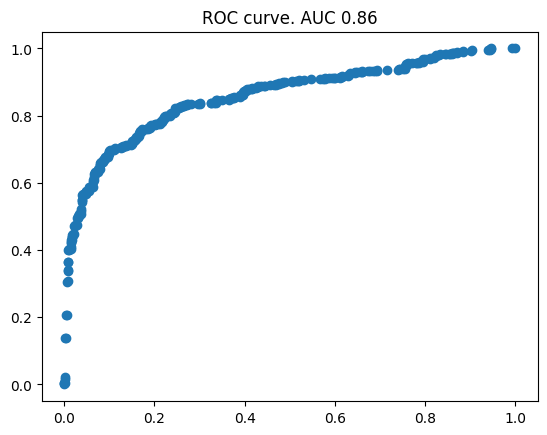

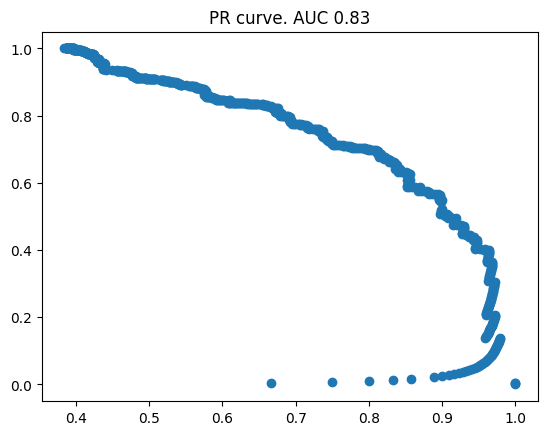

In [147]:
fpr, tpr, _ = roc_curve(y, probs[:,1])
auc_roc = roc_auc_score(y,probs[:,1])


prec, rec, _ = precision_recall_curve(y, probs[:,1])
auc_pr = auc(rec,prec)

plt.scatter(fpr,tpr)
plt.title(f'ROC curve. AUC {round(auc_roc,2)}')
plt.show()


plt.scatter(prec,rec)
plt.title(f'PR curve. AUC {round(auc_pr,2)}')
plt.show()

Com que les classes no estan balancejades, la corba PR és més adequada perquè es concentra en la precisió del model per identificar la classe positiva, ajudant a reduir els falsos negatius, que són més crítics en aquest context.

A més, la corba de precisió-recall considera el nombre de positius reals, fent-la més sensible als falsos positius. D'altra banda, la corba ROC pot resultar menys informativa en dades no equilibrades, ja que pot donar una falsa impressió de rendiment adequat si el ràtio de falsos positius és baix, mentre que els falsos positius poden ser comparables als positius reals.

**Classification report**

In [148]:
from sklearn.metrics import classification_report
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.78      0.70      0.74       342

    accuracy                           0.81       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.81      0.81      0.81       891



Aquest model té un rendiment global força bo, amb una precisió del 81%. Tot i que classifica bé la majoria de casos, el seu rendiment és lleugerament millor per als no supervivents que per als supervivents.


###MODEL SELECTION AMB VALIDACIÓ CREUADA

Fent servir la metrica trobada en l'apartat anterior, en aquest apartat caldrà seleccionar una serie de models i, fent ús de la validacio creuada, seleccionar el millor model amb els seus respectius millors hyperparametres que haurem buscat fent hyperparameter search.

Seleccionem aquests 4 models:

* Regressió logística: És un model de classificació que prediu la probabilitat que una instància pertanyi a una classe específica. Utilitza una funció logística per transformar la combinació lineal de les característiques d'entrada en una probabilitat, la qual es pot interpretar com a classes.

* Random Forest: És un model d'ensemble que crea múltiples arbres de decisió durant l'entrenament i combina les seves prediccions per millorar la precisió i controlar l'overfitting. Funciona bé en conjunt amb característiques que poden ser no lineals i ajuda a manejar dades amb valors nuls.

* K-Nearest Neighbors (KNN): És un algoritme de classificació basat en la similitud. Classifica una instància nova basant-se en les classes de les K instàncies més pròximes en l'espai de característiques. És senzill d'implementar, però pot ser lent per a conjunts de dades grans.

* Support Vector Machine (SVM): És un model que busca trobar un hiperpessant que separi les classes de manera òptima. Utilitza kernels per transformar les dades a un espai d'alta dimensió, permetent així manejar problemes no lineals. SVM és potent, però pot ser sensible als outliers i al paràmetre de regularització.

In [149]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived',axis=1),
                                                    df['Survived'], test_size=0.3,
                                                    random_state=111)


In [150]:
y=df['Survived']
y.mean(),y_test.mean(),y_train.mean()

(0.3838383838383838, 0.3619402985074627, 0.39325842696629215)

Veiem que les proporcions entre el dataset, les dades del train i les dades del test són molt similars, per tant, no és necessari aplicar estratificació.

Anem a realitzar el cross-validation pels diferents models.

Tant a la selecció de models, coma  la seleció de models amb hyperparametres, hem escollit un k-fold de 5 per al cross-validation perquè ofereix un bon equilibri entre precisió i temps de càlcul.

**Logistic Regression**

In [151]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

cv_scoresL = cross_val_score(lr,X_train,y_train,cv=StratifiedKFold(n_splits = 5),scoring='f1')
cv_scoresL.mean()

0.7327867644402704

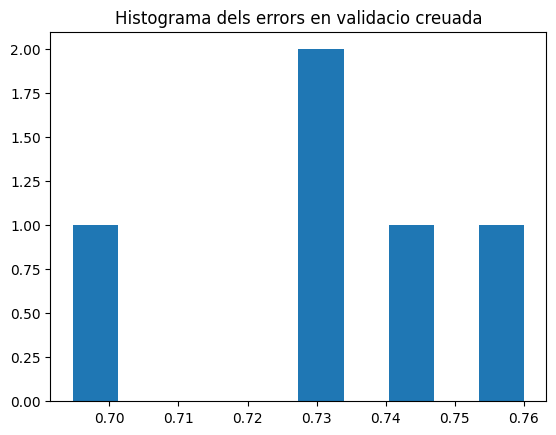

(0.7327867644402704, 0.021599525593013483, 0.7333333333333333)

In [152]:
plt.hist(cv_scoresL)
plt.title('Histograma dels errors en validacio creuada')
plt.show()

np.mean(cv_scoresL),np.std(cv_scoresL),np.median(cv_scoresL)

Amb el model de regressió logística obtenim una mitjana de F1 de 0.7328. La desviació estàndard de 0.0216 indica que els resultats són consistents, i la mediana de 0.7333 confirma l'estabilitat dels valors de cross-validation.

**KNN**

In [153]:
from sklearn.neighbors import KNeighborsClassifier
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

cv_scoresK = cross_val_score(knn, X_train, y_train,cv=StratifiedKFold(n_splits = 5),scoring = 'f1')
cv_scoresK.mean()

0.7070694336038565

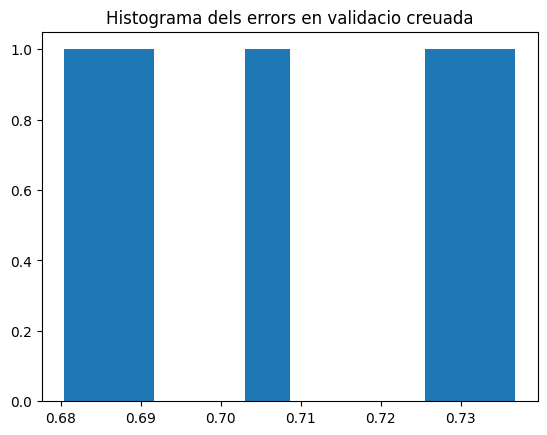

(0.7070694336038565, 0.022108746497512172, 0.7045454545454546)

In [154]:
plt.hist(cv_scoresK)
plt.title('Histograma dels errors en validacio creuada')
plt.show()

np.mean(cv_scoresK),np.std(cv_scoresK),np.median(cv_scoresK)

Amb el KNN hem obtingut una mitjana de F1 de 0.7071, amb una desviació estàndard de 0.0221 i una mediana de 0.7045. Això ens indica una lleugera variabilitat en els resultats.

**Random Forest**

In [155]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scoresR = cross_val_score(rf, X_train, y_train,cv=StratifiedKFold(n_splits = 5),scoring = 'f1')
cv_scoresR.mean()

0.7335598095355378

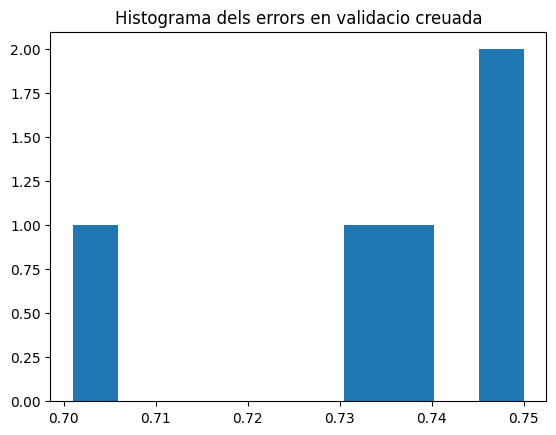

(0.7335598095355378, 0.017478352169761027, 0.7368421052631579)

In [156]:
plt.hist(cv_scoresR)
plt.title('Histograma dels errors en validacio creuada')
plt.show()

np.mean(cv_scoresR),np.std(cv_scoresR),np.median(cv_scoresR)

Amb el Random Forest hem obtingut una mitjana de F1 de 0.7336, amb una desviació estàndard de 0.0175 i una mediana de 0.7368, indicant que els resultats són els més consistents fins al moment.

**SVC**

In [157]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1.0, gamma=0.1, random_state=42)
cv_scoresS = cross_val_score(svm, X_train, y_train,cv=StratifiedKFold(n_splits = 5),scoring='f1')
cv_scoresS.mean()

0.7526298943774672

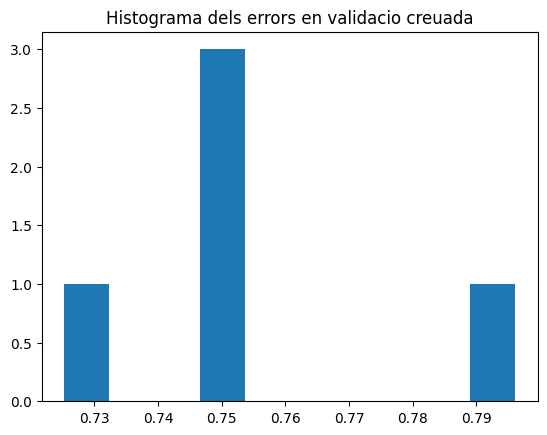

(0.7526298943774672, 0.02335008223117014, 0.7472527472527473)

In [158]:
plt.hist(cv_scoresS)
plt.title('Histograma dels errors en validacio creuada')
plt.show()

np.mean(cv_scoresS),np.std(cv_scoresS),np.median(cv_scoresS)

Per últim, amb el model SVC obtenim una mitjana de F1 de 0.7526, amb una desviació estàndard de 0.0234 i una mediana de 0.7473.

Considerant les mitjanes dels F1-score i les desviacions obtingudes per als quatre models analitzats, els models SVC i Random Forest presenten els millors resultats, sent les opcions més prometedores. El model KNN sembla menys adequat i podria ser descartat. No obstant això, abans de fer-ho, realitzarem una cerca d'hiperparàmetres mitjançant cross-validation. En els models SVC i Random Forest, buscarem ajustar hiperparàmetres com el coeficient de regularització, la profunditat de l'arbre i la selecció de característiques, entre d'altres, per maximitzar el seu rendiment i fiabilitat en la classificació. Per fer-ho, utilitzarem GridSearchCV.

**Logistic Regression**

In [159]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

lr = LogisticRegression()
param_grid = {
    'C': np.arange(0.1, 1, 0.1),
    'fit_intercept': [False, True],
    'penalty': ['l1', 'l2'],
}

gs = GridSearchCV(lr, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5))
gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [False, True],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [160]:
gs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_fit_intercept', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [161]:
gs.cv_results_['param_C'].data

array([0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4,
       0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7,
       0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9])

In [162]:
gs.best_params_

{'C': 0.1, 'fit_intercept': True, 'penalty': 'l2'}

In [163]:
gs.best_score_

0.7449462679947284

Donat que hem obtingut el valor més baix de C (0.1) dels del conjunt de paràmetres, per tant, ampliarem el rang de valors que explorem a la cerca d'hiperparàmetres i considerarem un valor de C encara més petit(0.05):

In [164]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

lr = LogisticRegression()

param_grid = {
    'C': np.arange(0.05, 1, 0.05),
    'fit_intercept': [True],
    'penalty': ['l2'],
}

gs = GridSearchCV(lr, param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5))
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'fit_intercept': [True], 'penalty': ['l2']},
             scoring='f1')

In [165]:
gs.best_params_

{'C': 0.1, 'fit_intercept': True, 'penalty': 'l2'}

El millor valor de C continua sent 0.1, per tant, aquest paràmetre proporciona un bon equilibri entre regularització i ajust del model. Això significa que el model de Regressió Logística és capaç de generalitzar bé sense sobreajustar-se.

**KNN**

In [166]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': list(range(1, 20, 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm' : ['ball_tree','kd_tree','brute']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits = 5),scoring = 'f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [167]:
grid_search.best_params_

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 13,
 'weights': 'uniform'}

In [168]:
grid_search.best_score_

0.753964864911531

**Random Forest**

In [169]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
   'n_estimators': [10,50, 100, 150],
    'max_depth': [3,5, 7, 10, 12, 14],
    'min_samples_split': [2, 5, 10, 12]

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10, 12, 14],
                         'min_samples_split': [2, 5, 10, 12],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='f1')

In [170]:
grid_search.best_params_

{'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 100}

In [171]:
grid_search.best_score_

0.7674223895476585

Observem que el millor valor per al paràmetre max_depth és 14. Aquesta configuració ha estat obtinguda amb un rang de valors entre el 3 i el 14, per tant, ampliarem el rang de max_depth incloent el 16 per veure si el model segueix seleccionant 14 com el millor valor:

In [172]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
param_grid = {
   'n_estimators': [10,50, 100, 150],
    'max_depth': [3,5, 7, 10, 12, 14, 16],
    'min_samples_split': [2, 5, 10, 12]

}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10, 12, 14, 16],
                         'min_samples_split': [2, 5, 10, 12],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='f1')

In [173]:
grid_search.best_params_

{'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 100}

Veiem que el model segueix sleccionant 14 com el millor valor, la qual cosa vol dir que amb profunditats mes grans el rendiment no millora significativament. L'elecció max_depth = 14 és fiable per maximitzar el rendiment del model sense caure en el sobreajustament.

**SVC**

In [174]:
from sklearn.svm import SVC
param_grid = {
    'C': [0.1, 1, 10, 100,150],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 150],
                         'gamma': [0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='f1')

In [175]:
grid_search.cv_results_['param_gamma'].data

array([0.1   , 0.1   , 0.01  , 0.01  , 0.001 , 0.001 , 0.0001, 0.0001,
       0.1   , 0.1   , 0.01  , 0.01  , 0.001 , 0.001 , 0.0001, 0.0001,
       0.1   , 0.1   , 0.01  , 0.01  , 0.001 , 0.001 , 0.0001, 0.0001,
       0.1   , 0.1   , 0.01  , 0.01  , 0.001 , 0.001 , 0.0001, 0.0001,
       0.1   , 0.1   , 0.01  , 0.01  , 0.001 , 0.001 , 0.0001, 0.0001])

In [176]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [177]:
grid_search.best_score_

0.7613692332744605

In [178]:
param_grid = {
    'C': [0.1, 1, 10, 100,150],
    'gamma': [10,1,0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 150],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='f1')

In [179]:
grid_search.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [180]:
grid_search.best_score_

0.7620969450832025

Veiem que el valor òptim de 'gamma' ara que hem ampliat el rang ha canviat. Per tant, ara que ja hem trobat el millor valor per tots els paràmetres, tornem a fer crossvalidation.


Ara que hem identificat els millors valors per als paràmetres dels diferents models, hem d'avaluar el seu rendiment mitjançant la validació creuada. Això ens permetrà verificar l'estabilitat i la robustesa d'aquests.

In [181]:
lr = LogisticRegression(C= 0.1, fit_intercept = True, penalty='l2',)
lr.fit(X_train,y_train)

cv_scoresL = cross_val_score(lr,X_train,y_train,scoring='f1')
cv_scoresL.mean()

0.7449462679947284

In [182]:
knn = KNeighborsClassifier(algorithm = 'ball_tree',metric = 'manhattan',n_neighbors =  13, weights =  'uniform')

cv_scoresK = cross_val_score(knn, X_train, y_train, cv=StratifiedKFold(n_splits = 5),scoring = 'f1')
cv_scoresK.mean()

0.753964864911531

In [183]:
rf = RandomForestClassifier(max_depth = 14, min_samples_split = 10, n_estimators= 100, random_state=42)

cv_scoresR = cross_val_score(rf, X_train, y_train, cv=5,scoring = 'f1')
cv_scoresR.mean()

0.7674223895476585

In [184]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, gamma=1, random_state=42,probability = True)

cv_scoresS = cross_val_score(svm, X_train, y_train, cv=5,scoring='f1')
cv_scoresS.mean()

0.7620969450832025

Els resultats indiquen que el Random Forest és el model més adequat per a la tasca de classificació, seguit pel SVC. El KNN i la Regressió Logística tenen rendiments més baixos, cosa que indica que podrien no ser tan eficients per a aquest conjunt de dades. Visualitzem aquests resultats:

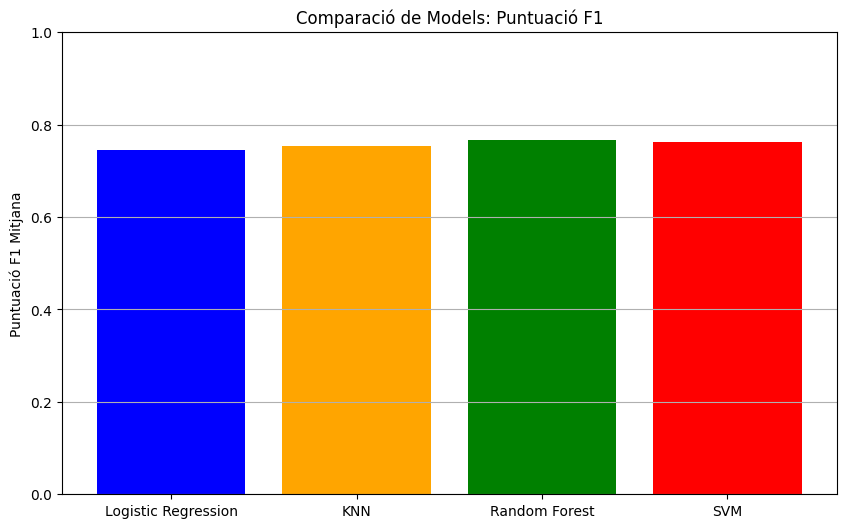

In [185]:
f1_scores = {
    'Logistic Regression': cv_scoresL.mean(),
    'KNN': cv_scoresK.mean(),
    'Random Forest': cv_scoresR.mean(),
    'SVM': cv_scoresS.mean()
}

plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Puntuació F1 Mitjana')
plt.title('Comparació de Models: Puntuació F1')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Com ja haviem vist abans, la diferència entre el SVC i el Random Forest és mínima. No obstant això, després de seleccionar els millors paràmetres, el Random Forest ha superat al SVC en rendiment. Per tant, serà el model que seleccionarem.

In [186]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_split=10, random_state=42)

##ANÀLISI FINAL

Amb el millor model seleccionat, ja podem començar a analitzar els resultats. Primer, analitzarem la corba PR (Precision-Recall) ja que ens ofereix una millor mesura per avaluar el rendiment del model quan tenim dades desbalancejades.

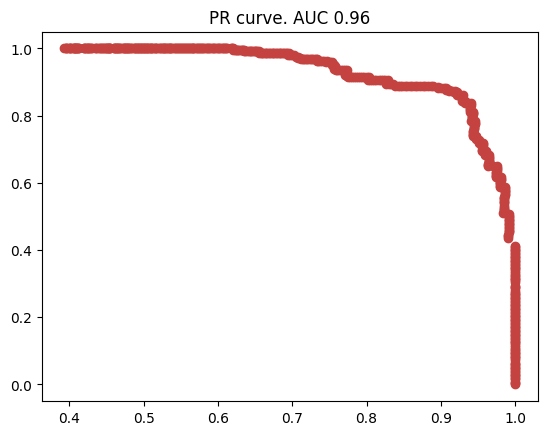

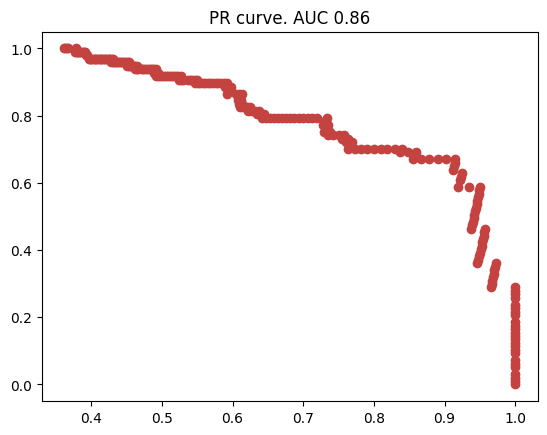

In [187]:
probs = rf.predict_proba(X_train)
probs_test = rf.predict_proba(X_test)

prec, rec, _ = precision_recall_curve(y_train, probs[:,1])
auc_pr = auc(rec,prec)

prec_test, rec_test, _ = precision_recall_curve(y_test, probs_test[:,1])
auc_pr_test = auc(rec_test,prec_test)

plt.scatter(prec,rec, color='xkcd:reddish')
plt.title(f'PR curve. AUC {round(auc_pr,2)}')
plt.show()
plt.scatter(prec_test,rec_test, color='xkcd:reddish')
plt.title(f'PR curve. AUC {round(auc_pr_test,2)}')
plt.show()

En el conjunt de test, l'AUC és 0.86, indicant un bon rendiment, però amb possibilitat de millora. En el conjunt de train, l'AUC és 0.96, mostrant un ajust molt bo al conjunt d'entrenament. Aquest tant bon ajust, pot indicar que hi ha una mica d'verfitting. Tot i així, les corbes són bastant similars, indicant un bon model de predicció.

El pròxim resultat a analitzar és l'accuracy i el f1_score obtingut en el test:

In [188]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_test, y_pred)

print(f'F1 Score: {f1:.2f}')

Accuracy: 0.83
F1 Score: 0.75


Després d'aplicar el Random Forest a les dades, hem obtingut una acuuracy de 0.83, la qual cosa indica que el model ha classificat correctament el 83% de les mostres. Pel que fa al F1-score hem obtingut un valor de 0.75, la qual cosa mostra que el model equilibra la precissió i el record.

[[154  17]
 [ 29  68]]
[0.84153005 0.8       ] [0.9005848  0.70103093] [0.8700565  0.74725275] [171  97]


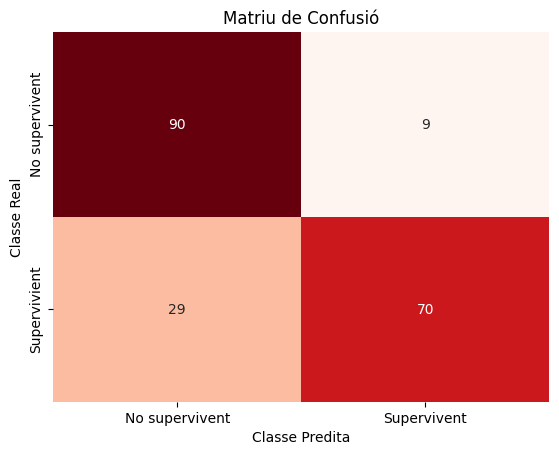

In [189]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

conf = confusion_matrix(y_test,y_pred)

prec,rec,f1, sup = precision_recall_fscore_support(y_test,y_pred)
print(conf)
print(prec, rec, f1, sup)

conf_perc=np.array(100*conf.T/conf.sum(axis = 1),dtype = int).T
sns.heatmap(conf_perc, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=['No supervivent', 'Supervivent'], yticklabels=['No supervivent', 'Supervivient'])

plt.title('Matriu de Confusió')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')

plt.show()

El model té una gran capacitat per identificar correctament la classe No Supervivent amb un Recall de 0.90, el que significa que el 90% dels casos reals de "No Supervivent" han estat classificats correctament. El Recall per a la classe Supervivent és més baix (0.70), cosa que indica que el model té més dificultats per identificar correctament els supervivents.


**CAS D'ÚS**

Volem aprofundir en el comportament del nostre model de classificació respecte a la supervivència en funció del sexe. Històricament, s'ha considerat que en situacions d'emergència, com va ser el cas del Titanic, es prioritzava el rescat de dones i nens. Així que, volem investigar si aquestes dades mostren un patró similar, i si el model que hem entrenat reflexa aquest comportament. Per fer-ho hem calculat el percentatge de supervivència per homes i dones i hem fet matrius de confusió separades per sexe per avaluar els encerts i errors del model.

In [190]:
male_value = X_test['Sex'].min()  #Als homes els hi correspon el 0, per tant, el valor mínim
female_value = X_test['Sex'].max()  #A les dones els hi correspon el 1, per tant, el valor màxim

y_test_df = pd.DataFrame({'Survived': y_test, 'Predicted': y_pred, 'Sex': X_test['Sex']})
y_test_df['Sex'] = y_test_df['Sex'].replace({male_value: 'Home', female_value: 'Dona'})

total_dones = y_test_df[y_test_df['Sex'] == 'Dona'].shape[0]
total_homes = y_test_df[y_test_df['Sex'] == 'Home'].shape[0]

supervivents_dones = y_test_df[(y_test_df['Sex'] == 'Dona') & (y_test_df['Survived'] == 1)].shape[0]
supervivents_homes = y_test_df[(y_test_df['Sex'] == 'Home') & (y_test_df['Survived'] == 1)].shape[0]

percentatge_dones = (supervivents_dones / total_dones) * 100 if total_dones > 0 else 0
percentatge_homes = (supervivents_homes / total_homes) * 100 if total_homes > 0 else 0

print(f'Percentatge de supervivència de dones: {percentatge_dones:.2f}%')
print(f'Percentatge de supervivència d homes: {percentatge_homes:.2f}%')

# Matriu de confusió homes
y_true_male = y_test_df[y_test_df['Sex'] == 'Home']['Survived']
y_pred_male = y_test_df[y_test_df['Sex'] == 'Home']['Predicted']
confusion_male = confusion_matrix(y_true_male, y_pred_male)

# Matriu de confusió dones
y_true_female = y_test_df[y_test_df['Sex'] == 'Dona']['Survived']
y_pred_female = y_test_df[y_test_df['Sex'] == 'Dona']['Predicted']
confusion_female = confusion_matrix(y_true_female, y_pred_female)


print("\nMatriu de Confusió Homes:")
print(confusion_male)

print("\nMatriu de Confusió Dones:")
print(confusion_female)


Percentatge de supervivència de dones: 69.15%
Percentatge de supervivència d homes: 18.39%

Matriu de Confusió Homes:
[[134   8]
 [ 21  11]]

Matriu de Confusió Dones:
[[20  9]
 [ 8 57]]


Mentre que el percentatge de supervivència de les dones és considerablement superior al 50% (69.15%), el dels homes és significativament inferior (18.39%).
Donats aquests resultats podem concloure que les dades reflecteixen clarament una major probabilitat de supervivència per a les dones comparat amb els homes, la qual cosa reforça la idea històrica que en situacions d'emergència es va donar prioritat al rescat de les dones.

El model mostra un comportament més precís a l'hora de predir la supervivència de les dones, tal com es veu en la matriu de confusió, amb menys errors que en el cas dels homes.

Per tal de reforçar la idea anterior, predim amb el model per dues persones amb les mateixes característiques, però amb diferent sexe.

In [191]:
data = {

    'Pclass': [0.827377, 0.827377],
    'Sex': [1, 0],
    'Age': [0.67, 0.67],
    'SibSp': [0.0, 0.0],
    'Parch': [0.0, 0.0],
    'Fare': [0.85, 0.85],
    'Embarked_Q': [1, 1],
    'Embarked_C': [0, 0],
    'Embarked_S': [0, 0]


      # 0 per dona, 1 per home
}
df_1 = pd.DataFrame(data)

# Mostrar el DataFrame
print(df_1)

     Pclass  Sex   Age  SibSp  Parch  Fare  Embarked_Q  Embarked_C  Embarked_S
0  0.827377    1  0.67    0.0    0.0  0.85           1           0           0
1  0.827377    0  0.67    0.0    0.0  0.85           1           0           0


In [192]:
pel_pred1 = rf.predict(df_1)
print(pel_pred1)

[1 0]


Confirmem que amb les mateixes dades, però amb sexes diferents, la dona sobreviu i l'home no.

In [193]:
data = {

    'Pclass': [0.827377, 0.827377],
    'Sex': [0, 1],
    'Age': [0.125, 0.67],
    'SibSp': [0.0, 0.0],
    'Parch': [0.0, 0.0],
    'Fare': [0.85, 0.85],
    'Embarked_Q': [1, 0],
    'Embarked_C': [0, 0],
    'Embarked_S': [0, 1]

}
df_2 = pd.DataFrame(data)

print(df_2)
pel_pred2 = rf.predict(df_2)
print(pel_pred2)

     Pclass  Sex    Age  SibSp  Parch  Fare  Embarked_Q  Embarked_C  \
0  0.827377    0  0.125    0.0    0.0  0.85           1           0   
1  0.827377    1  0.670    0.0    0.0  0.85           0           0   

   Embarked_S  
0           0  
1           1  
[1 1]


Si canviem les dades de l'home per representar un nen de classe alta, mantenint les altres característiques iguals a l'exemple anterior, on l'home no sobreviuria, aquest cop, el nen sí que ho faria..

Aquesta diferència es pot explicar pel fet que, en els bots salvavides, les primeres persones a pujar-hi, i gairebé les úniques, van ser dones i nens, prioritzant així la seva seguretat.

##CONCLUSIONS DEL MODEL:
---

Al llarg d’aquest projecte, hem desenvolupat un model predictiu per estimar les probabilitats de supervivència dels passatgers del Titanic, utilitzant diferents tècniques de *machine learning*. Hem fet des de la preparació de les dades fins a la selecció i validació de models, per assegurar que les nostres prediccions siguin fiables.

Amb l'anàlisi incial de les dades hem vist que variables com el sexe, la classe del bitllet i l'edat tenien un fort impacte en la supervivència. Destacant especialment la diferèncièa entre homes i dones.

Després de provar diversos models com la Regressió Logística, K-Nearest Neighbors (KNN), SVC, i Random Forest, aquest últim ha estat el més efectiu, amb una **accuracy del 83%** i un **F1-score de 0.75**. És a dir, ha estat el model capaç d'oferir millors prediccions.

Els resultats de la comparació per sexe ens han confirmat les expectatives: les dones van tenir una taxa de supervivència molt més alta (69.15%) que els homes (18.39%), cosa que corrobora que es va complir la norma de "dones i nens primer".

En general, hem aconseguit crear un model predictiu sòlid, que reflecteix tant les dades com el context històric. Tot i els bons resultats, hi ha marge per millorar, sobretot en la predicció per als homes, que podria afinar-se amb més dades o tècniques avançades.

Aquest projecte ens ha mostrat com el *machine learning* pot ajudar a analitzar fets històrics i oferir noves perspectives sobre els factors que influeixen en situacions d'emergència. Els resultats ens han deixat amb ganes de comparar els factors més rellevants de la supervivència en aquell moment amb els que hi hauria avui en dia en circumstàncies similars. Aquesta comparació podria aportar informació interessant i útil per entendre com ha evolucionat la situació social davant d'emergències.

###MILLORES AL MODEL:

Per tal de millorar el nostre model de predicció, una de les accions que podríem haver implementat si haguéssim tingut més temps és la detecció i eliminació de possibles outliers. Els valors atípics poden distorsionar els resultats del model, especialment en algunes tècniques que són sensibles a aquests valors extrems.

A més, hauríem pogut provar una gamma més àmplia de models de classificació per tenir més opcions a l'hora de triar el model que millor s'adapti al conjunt de dades, com per exemple el model Gradient Boosting.

Una altra millora que es podria haver considerat és entrenar models específics per a cada sexe, ja que hem vist que en el nostre cas hi ha dificultats per predir als homes correctament.

